# Data pre-processing

Yannik Schaelte

Square the data, apply random transformations, and weight classes in the loss function.

## Load data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import os

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from torchvision import models, transforms

from sklearn.model_selection import train_test_split, KFold

# Convenience functions
id2loc = lambda id_: f'data/img_{id_}.png'
id2img = lambda id_: Image.open(id2loc(id_))
img2arr = lambda img: np.array(img)
id2arr = lambda id_: img2arr(id2img(id_))

imgt2img = lambda imgt: transforms.ToPILImage()(imgt)
imgt2arr = lambda imgt: img2arr(imgt2img(imgt))

# Load labels
labels = pd.read_csv('data/labels.csv', sep=',')
# Convert to >= 0
labels["malignant"] += 1

label2text = {
    0: 'negative',
    1: 'benign',
    2: 'malignant'
}
text2label = {v: k for k, v in label2text.items()}

labels.head(10)

id  malignant
0     441          0
1   33284          0
2   38771          2
3   46784          0
4   57613          0
5   74682          1
6   78884          1
7   93760          1
8   98327          1
9  112905          1

In [2]:
labels_negative = labels[labels["malignant"]==0]
labels_benign = labels[labels["malignant"]==1]
labels_malignant = labels[labels["malignant"]==2]

In [3]:
# Class weights
weights = 1. / labels["malignant"].value_counts()
# To array
weights = np.array([weights[key] for key in [0, 1, 2]])
# To tensor
weights = torch.tensor(weights, dtype=torch.float)
weights

tensor([0.0278, 0.0714, 0.0833])

## Explore

In [4]:
print("Number of negative labels: ", len(labels_negative))
print("Number of benign labels: ", len(labels_benign))
print("Number of malignant labels: ", len(labels_malignant))
print("Total number of labels: ", len(labels))

Number of negative labels:  36
Number of benign labels:  14
Number of malignant labels:  12
Total number of labels:  62


Let's plot some images from all classes:

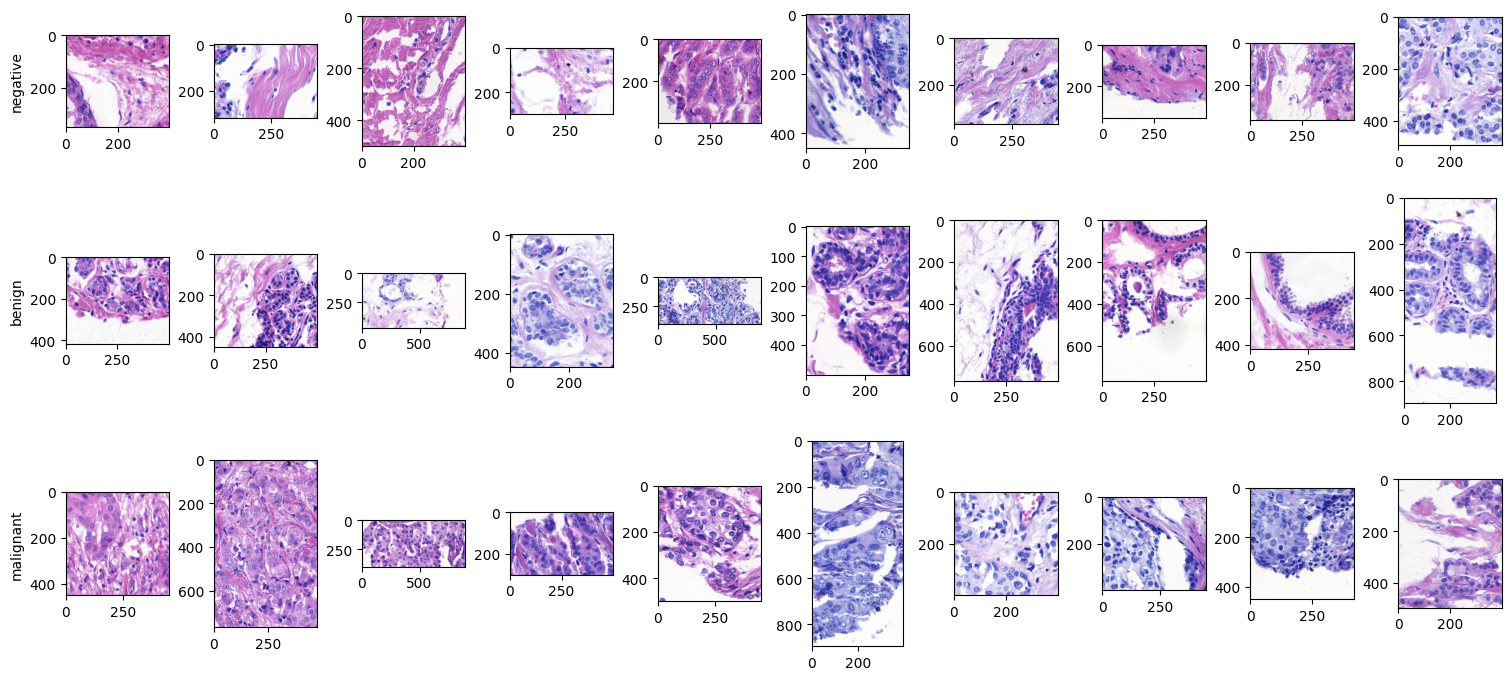

In [5]:
n_fig = 10
fig, axes = plt.subplots(3, n_fig, figsize=(15, 7), constrained_layout=True)

for i in range(n_fig):
    axes[0, i].imshow(id2arr(labels_negative.iloc[i]["id"]))
    axes[1, i].imshow(id2arr(labels_benign.iloc[i]["id"]))
    axes[2, i].imshow(id2arr(labels_malignant.iloc[i]["id"]))
for key, val in label2text.items():
    axes[key, 0].set_ylabel(val);

Let's inspect some in more detail:

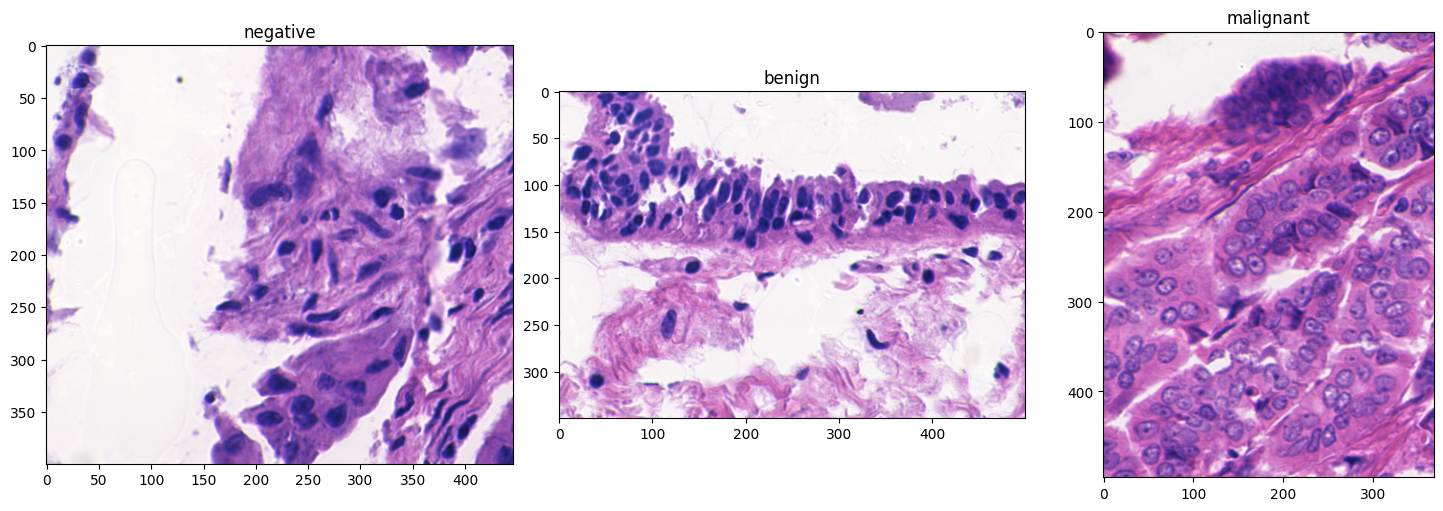

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

axes[0].imshow(id2arr(labels_negative.iloc[11]["id"]))
axes[1].imshow(id2arr(labels_benign.iloc[11]["id"]))
axes[2].imshow(id2arr(labels_malignant.iloc[11]["id"]))
for key, val in label2text.items():
    axes[key].set_title(val);

Of note is the heterogeneity of image sizes and shapes. Let's inspect that further:

In [7]:
dims = [id2arr(labels.iloc[i]["id"]).shape for i in range(len(labels))]
dims = pd.DataFrame(dims, columns=["width", "height", "channels"])
dims.describe()

width      height  channels
count   62.000000   62.000000      62.0
mean   469.548387  464.516129       3.0
std    149.680937  144.946428       0.0
min    268.000000  300.000000       3.0
25%    368.000000  400.000000       3.0
50%    446.000000  419.500000       3.0
75%    496.000000  490.750000       3.0
max    896.000000  896.000000       3.0

In [8]:
# maximum width or height
max_dim = max(dims["width"].max(), dims["height"].max())
max_dim

896

## Preprocessing

In [9]:
# apply ResNet50 transformations
# transform = models.ResNet50_Weights.IMAGENET1K_V2.transforms()

class SquarePad:
    """Square the image."""
    def __init__(self, fill=0):
        self.fill = fill

    def __call__(self, image):
        width, height = image.size

        # Calculate the padding size
        if width > height:
            padding = (0, (width - height) // 2, 0, (width - height) // 2)
        else:
            padding = ((height - width) // 2, 0, (height - width) // 2, 0)

        # Pad the image
        image = transforms.functional.pad(image, padding, fill=self.fill)

        return image

transform_basic = transforms.Compose(
    [
        SquarePad(),
        transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ],
)

transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transform_basic,
    ],
)

# Should be equivalent to:
# transform = transforms.Compose(
#     [
#         transforms.Resize(
#             256,
#             interpolation=transforms.InterpolationMode.BILINEAR,
#         ),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225],
#         ),
#     ],
# )

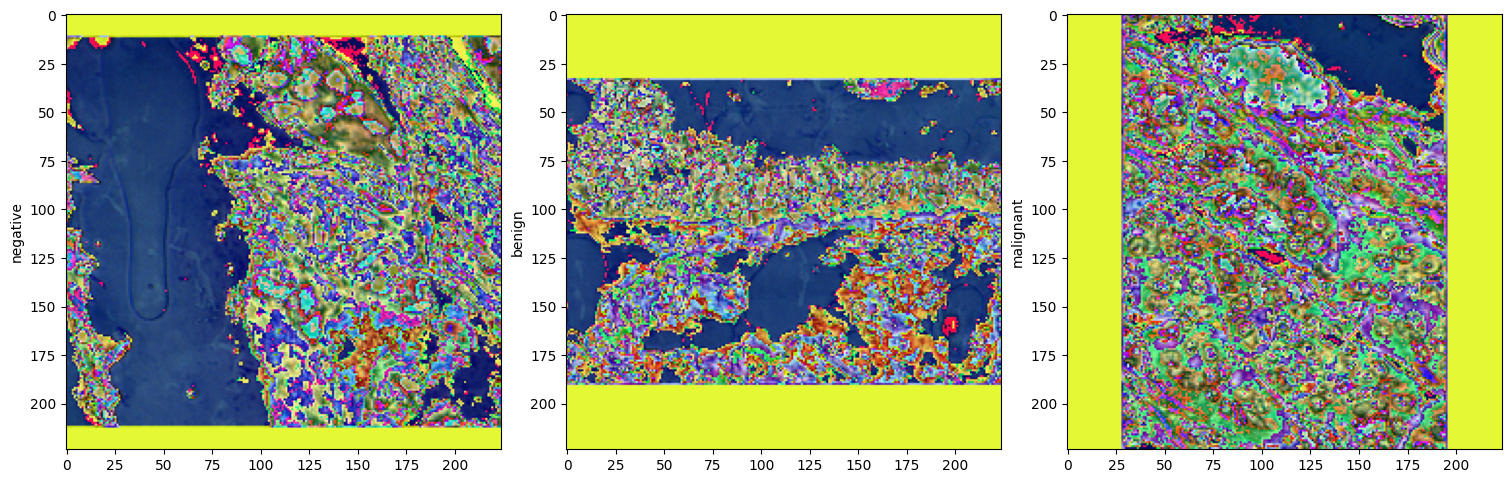

In [10]:
# Visualize transformed images

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

axes[0].imshow(imgt2arr(transform(id2img(labels_negative.iloc[11]["id"]))))
axes[1].imshow(imgt2arr(transform(id2img(labels_benign.iloc[11]["id"]))))
axes[2].imshow(imgt2arr(transform(id2img(labels_malignant.iloc[11]["id"]))))
for key, val in label2text.items():
    axes[key].set_ylabel(val);

In [11]:
class CarcinomaDataset(Dataset):
    def __init__(self, labels, transform=None, target_transform=None, id2img=None):
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        if id2img is None:
            id2loc = lambda id_: f'data/img_{id_}.png'
            id2img = lambda id_: Image.open(id2loc(id_))
        self.id2img = id2img

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        id_, label = self.labels.iloc[idx][["id", "malignant"]]
        img = self.id2img(id_)
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return img, label
    
# Create the dataset
dataset = CarcinomaDataset(labels, transform=transform)
# Create the dataloader
# #data is 62 >= 2 * 32
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

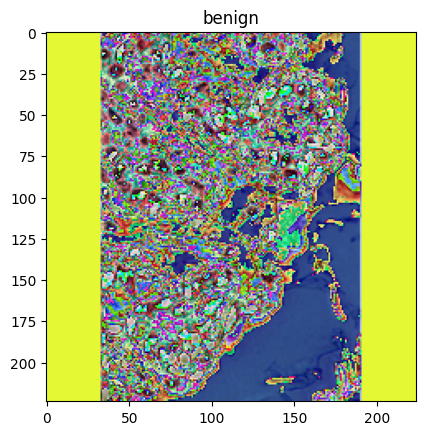

In [12]:
# test dataloader

_imgs, _labels = next(iter(dataloader))
plt.imshow(imgt2arr(_imgs[0]))
plt.title(label2text[int(_labels[0])]);

## Fine-tune Pre-trained ResNet50 model

In [13]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
device

device(type='cpu')

In [14]:
# Load model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Freeze all parameters except the last 2 layers


# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
# Number of inputs for linear layer
num_features = model.fc.in_features
num_classes = 3
model.fc = nn.Linear(num_features, num_classes)

# Move model to device
model = model.to(device)

# Define loss function
loss = nn.CrossEntropyLoss(weight=weights)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_epoch(model, dataloader, loss, optimizer, device):
    """Train function for one epoch."""
    model.train()
    for _imgs, _labels in dataloader:
        # Move data to device
        _imgs = _imgs.to(device)
        _labels = _labels.to(device)
        # Zero the gradients (otherwise they are accumulated)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(_imgs)
        # Compute loss
        loss_value = loss(outputs, _labels)
        # Backward pass
        loss_value.backward()
        # Update parameters
        optimizer.step()
    return loss_value
    
def train(model, dataloader, loss, optimizer, device, num_epochs=100):
    """Train function."""
    # Set model to training mode
    for epoch in range(num_epochs):
        loss_value = train_epoch(model, dataloader, loss, optimizer, device)
        print(f"Epoch {epoch+1}/{num_epochs} loss: {loss_value:.4f}")

In [15]:
# Number of parameters
print("Number of parameters:", sum(p.numel() for p in model.parameters()))
print("Number of trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of parameters: 23514179
Number of trainable parameters: 6147


In [16]:
torch.manual_seed(0)

# Train the model
train(model, dataloader, loss, optimizer, device, num_epochs = 100)

Epoch 1/100 loss: 1.1070
Epoch 2/100 loss: 1.0083
Epoch 3/100 loss: 0.9991
Epoch 4/100 loss: 0.9142
Epoch 5/100 loss: 0.9328
Epoch 6/100 loss: 0.8589
Epoch 7/100 loss: 0.8011
Epoch 8/100 loss: 0.7660
Epoch 9/100 loss: 0.7623
Epoch 10/100 loss: 0.8270
Epoch 11/100 loss: 0.7219
Epoch 12/100 loss: 0.6993
Epoch 13/100 loss: 0.6749
Epoch 14/100 loss: 0.5922
Epoch 15/100 loss: 0.6001
Epoch 16/100 loss: 0.5879
Epoch 17/100 loss: 0.5910
Epoch 18/100 loss: 0.5668
Epoch 19/100 loss: 0.5355
Epoch 20/100 loss: 0.5683
Epoch 21/100 loss: 0.5785
Epoch 22/100 loss: 0.4777
Epoch 23/100 loss: 0.5518
Epoch 24/100 loss: 0.5542
Epoch 25/100 loss: 0.4992
Epoch 26/100 loss: 0.4779
Epoch 27/100 loss: 0.4295
Epoch 28/100 loss: 0.4411
Epoch 29/100 loss: 0.3765
Epoch 30/100 loss: 0.4498
Epoch 31/100 loss: 0.5567
Epoch 32/100 loss: 0.3936
Epoch 33/100 loss: 0.4475
Epoch 34/100 loss: 0.3909
Epoch 35/100 loss: 0.3280
Epoch 36/100 loss: 0.3969
Epoch 37/100 loss: 0.3493
Epoch 38/100 loss: 0.3240
Epoch 39/100 loss: 0.

## Predict

In [17]:
# Gather test set
# The validation set is the set of images that are not contained in labels.to_csv

training_ids = set(labels["id"])
test_ids = []
# Iterate through PNG files in data directory
for file in os.listdir("data"):
    # Check if file is a PNG file
    if file.endswith(".png"):
        # Extract id
        id_ = int(file[4:-4])
        # Check if id is in training set
        if id_ not in training_ids:
            test_ids.append(id_)

assert len(test_ids) + len(labels) == 186

In [18]:
# Set model to evaluation mode
model.eval()

# Predict labels on test set
test_labels = []
for id_ in test_ids:
    # Load image
    img = id2img(id_)
    # Apply transformations
    img = transform_basic(img)
    # Add batch dimension
    img = img.unsqueeze(0)
    # Move to device
    img = img.to(device)
    # Predict
    label = torch.argmax(model(img)).item()
    # Save label
    test_labels.append(label)

# Create dataframe from ids and labels
test_labels = pd.DataFrame({"id": test_ids, "malignant": test_labels})
# Sort
test_labels.sort_values(by="id", inplace=True)
test_labels

id  malignant
86    5042          1
53   28148          0
95   35946          2
89   37944          2
29   39157          1
..     ...        ...
71  959476          1
13  968389          0
80  976505          2
5   996288          2
41  997841          2

[124 rows x 2 columns]

In [19]:
print("Number of negative labels: ", len(test_labels[test_labels["malignant"] == 0]))
print("Number of benign labels: ", len(test_labels[test_labels["malignant"] == 1]))
print("Number of malignant labels: ", len(test_labels[test_labels["malignant"] == 2]))
print("Total number of labels: ", len(test_labels))

Number of negative labels:  58
Number of benign labels:  33
Number of malignant labels:  33
Total number of labels:  124


In [20]:
# Store as submission
# Offset by -1 to get original labels
submission = test_labels.copy()
submission["malignant"] -= 1
submission.to_csv("submission.csv", index=False)

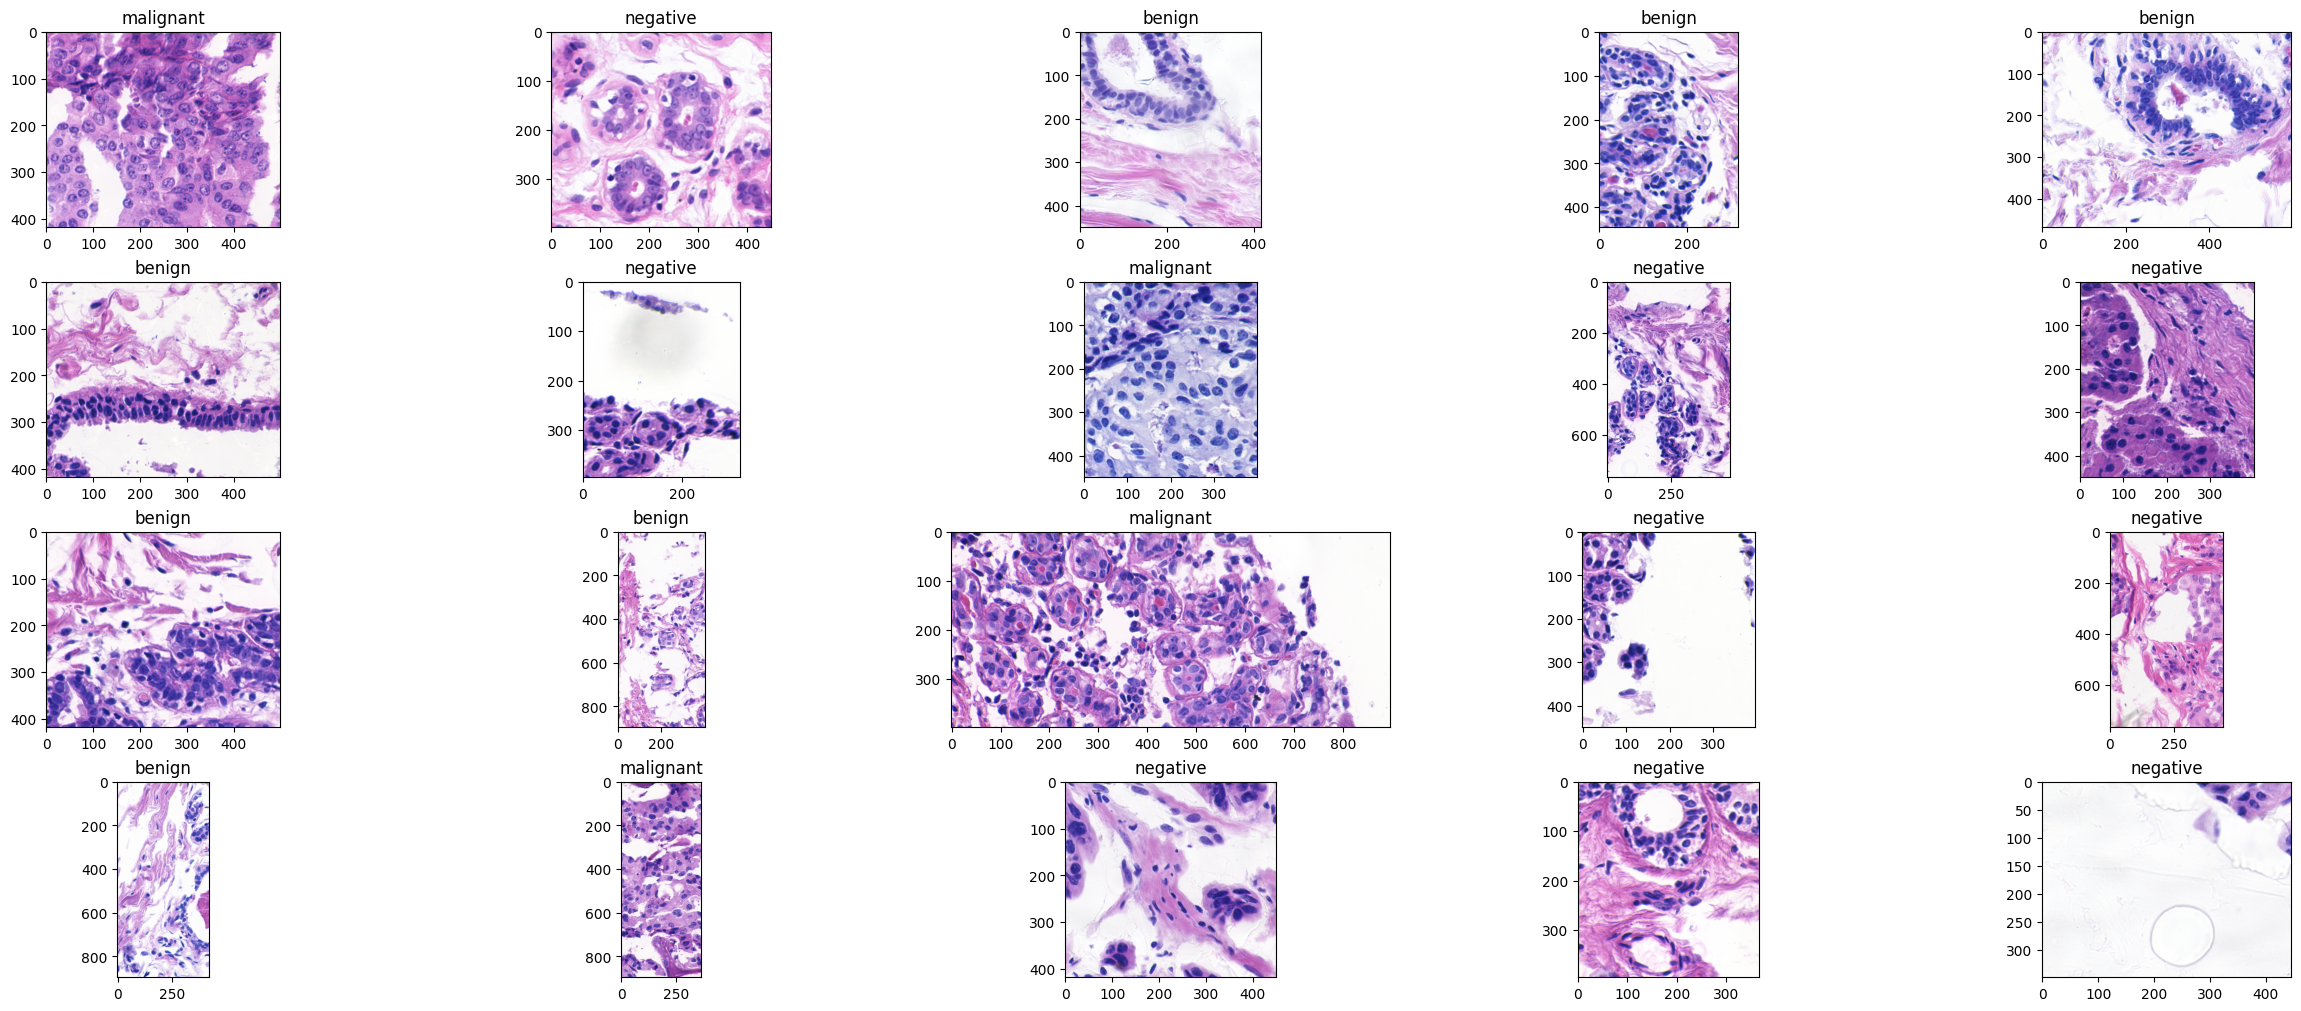

In [21]:
# Visualize some predictions

n_row, n_col = 4, 5
n_fig = n_row * n_col
fig, axes = plt.subplots(n_row, n_col, figsize=(5 * n_col, 2.5 * n_row), constrained_layout=True)
axes = axes.flatten()
# Sample n_fig random ids
ids = np.random.choice(test_ids, size=n_fig, replace=False)
for i, id_ in enumerate(ids):
    axes[i].imshow(id2arr(id_))
    axes[i].set_title(label2text[test_labels[test_labels["id"] == id_]["malignant"].item()]);